In [1]:
import os
import sys
parent_dir = os.path.abspath(os.path.join(os.path.dirname(__file__), ".."))
sys.path.append(parent_dir)
os.environ["EQX_ON_ERROR"] = "nan"
import jax
import jax.numpy as jnp
import jax_cosmo as jc
from functools import partial
from jaxdecomp import ShardedArray

from jaxpm.painting import cic_paint_dx
from jaxpm.pm import linear_field, lpt
from diffrax import (
    ConstantStepSize,
    ODETerm,
    diffeqsolve,
    Tsit5,
    RecursiveCheckpointAdjoint,
)

import matplotlib.pyplot as plt
from tqdm import tqdm
from tools.finite_difference import numerical_jvp
from tools.ode import symplectic_ode, DriftODETerm, DoubleKickODETerm, KickODETerm
from tools.integrate import integrate
from tools.semi_implicite_euler import SemiImplicitEuler
from tools.fast_pm import EfficientLeapFrog


from pmesh.pm import ParticleMesh

import numpy as np
from fastpm.core import Cosmology as FastPMCosmology, Solver, leapfrog

from typing import NamedTuple
from enum import Enum

jax.config.update("jax_enable_x64", True)

In [2]:
import os

os.makedirs("plots", exist_ok=True)

In [3]:
mesh_shape = [64, 64, 64]
box_size = [512.0, 512.0, 512.0]

omega_c = 0.25
sigma8 = 0.8
cosmo = jc.Planck15(Omega_c=omega_c, sigma8=sigma8)

# Generate initial particle positions
pm = ParticleMesh(BoxSize=box_size, Nmesh=mesh_shape, dtype="f8")
grid = pm.generate_uniform_particle_grid(shift=0).astype(np.float64)
# Interpolate with linear_matter spectrum to get initial density field
k = jnp.logspace(-4, 1, 128)
pk = jc.power.linear_matter_power(cosmo, k)

whitec = pm.generate_whitenoise(42, type="complex", unitary=False)


def pk_fn(x):
    return jnp.interp(x.reshape([-1]), k, pk).reshape(x.shape)


lineark = whitec.apply(
    lambda k, v: pk_fn(sum(ki**2 for ki in k) ** 0.5) ** 0.5
    * v
    * (1 / v.BoxSize).prod() ** 0.5
)
init_mesh = lineark.c2r().value
ref_cosmo = FastPMCosmology(cosmo)
solver = Solver(pm, ref_cosmo, B=1)


initial_conditions = ShardedArray(jnp.asarray(init_mesh))

In [4]:
class GradientType(Enum):
    Checkpoint = "Checkpoint"
    Reverse = "Reverse"


CHECKPOINT = GradientType.Checkpoint
REVERSE = GradientType.Reverse


class Params(NamedTuple):
    Omega_c: float
    sigma8: float


@jax.jit
def run_lpt(params, ic):
    cosmo = jc.Planck15(Omega_c=params.Omega_c, sigma8=params.sigma8)
    dx, p, _ = lpt(cosmo, ic, a=0.1, order=1)
    return dx, p


@partial(jax.jit, static_argnums=(2, 3, 4, 5, 6, 7))
def run_nbody(
    params,
    ic,
    terms,
    step_size=0.01,
    stepsize_controller=ConstantStepSize(),
    solver=Tsit5(),
    adjoint=CHECKPOINT,
    checkpoints=100,
):
    dx, p = run_lpt(params, ic)
    cosmo = jc.Planck15(Omega_c=params.Omega_c, sigma8=params.sigma8)
    y0 = (dx, p)
    if len(terms) == 3:
        *terms, first_kick_term = terms
        y0 = solver.first_step(
            first_kick_term, t0=0.1, dt0=step_size, y0=y0, args=cosmo
        )
        terms = tuple(terms)

    # Evolve the simulation forward
    if adjoint == CHECKPOINT:
        ode_solutions = diffeqsolve(
            terms,
            solver=solver,
            t0=0.1,
            t1=1.0,
            dt0=step_size,
            y0=y0,
            args=cosmo,
            stepsize_controller=stepsize_controller,
            adjoint=RecursiveCheckpointAdjoint(checkpoints=checkpoints),
        )
        last_y = jax.tree.map(lambda x: x[-1], ode_solutions.ys)
        num_steps = ode_solutions.stats["num_steps"]
        return last_y[0], num_steps

    elif adjoint == REVERSE:
        t0, t1 = 0.1, 1.0
        ode_solutions = integrate(
            y0, cosmo, terms, solver=solver, t0=t0, t1=t1, dt0=step_size
        )
        return ode_solutions[0], (t1 - t0) / step_size

    else:
        raise ValueError(f"Unknown adjoint method {adjoint}")

    return ode_solutions

In [5]:
def MSE(x, y):
    return jnp.mean((x.data - y.data) ** 2)


@jax.jit
def lpt_model(params, ic, obs):
    dx, p = run_lpt(params, ic)
    return MSE(cic_paint_dx(dx), obs)


@partial(jax.jit, static_argnums=(3, 4, 5, 6, 7, 8))
def model(
    params,
    ic,
    obs,
    term,
    step_size=0.01,
    stepsize_controller=ConstantStepSize(),
    solver=Tsit5(),
    adjoint=CHECKPOINT,
    checkpoints=100,
):
    y_hat, num_steps = run_nbody(
        params, ic, term, step_size, stepsize_controller, solver, adjoint, checkpoints
    )
    y_hat_field = cic_paint_dx(y_hat)

    return MSE(y_hat_field, obs), num_steps


nbody = jax.jit(model, static_argnums=(3, 4, 5, 6, 7, 8))

nbody_cosmo = jax.jit(jax.grad(model, has_aux=True), static_argnums=(3, 4, 5, 6, 7, 8))
nbody_ic = jax.jit(
    jax.grad(model, argnums=1, has_aux=True), static_argnums=(3, 4, 5, 6, 7, 8)
)

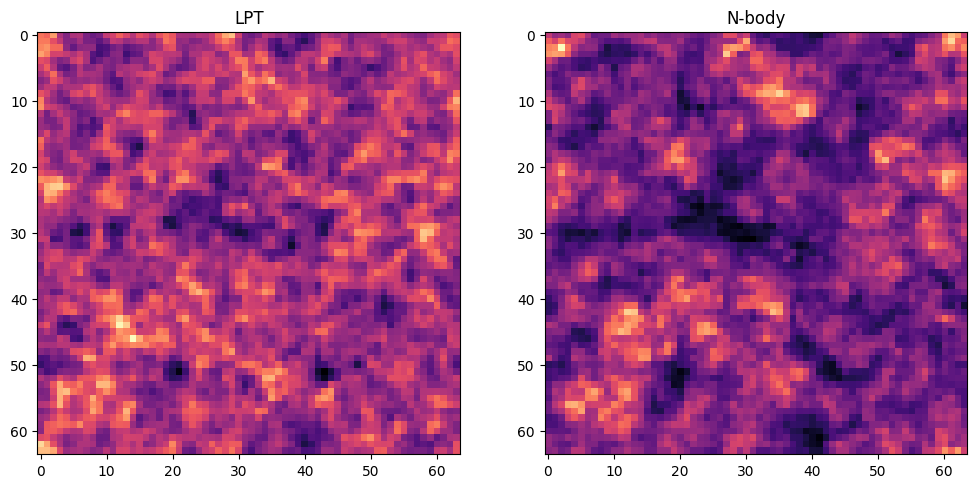

In [6]:
params = Params(0.25, 0.8)

ode_terms = jax.tree.map(
    lambda x: ODETerm(x), symplectic_ode(mesh_shape, paint_absolute_pos=False)
)
final_field, _ = run_nbody(
    params,
    initial_conditions,
    ode_terms,
    step_size=0.1,
    solver=SemiImplicitEuler(),
)
lpt_dx, _ = run_lpt(params, initial_conditions)

sie_field = cic_paint_dx(final_field)
lpt_field = cic_paint_dx(lpt_dx)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(lpt_field[10:].sum(axis=0).data, cmap="magma")
plt.title("LPT")
plt.subplot(122)
plt.imshow(sie_field[10:].sum(axis=0).data, cmap="magma")
plt.title("N-body")
plt.show()

In [7]:
best_params = params
guess_params = Params(Omega_c=0.8, sigma8=0.8)

best_grad, _ = nbody_cosmo(
    best_params,
    initial_conditions,
    sie_field,
    ode_terms,
    step_size=0.1,
    solver=SemiImplicitEuler(),
)
guess_grad, _ = nbody_cosmo(
    guess_params,
    initial_conditions,
    sie_field,
    ode_terms,
    step_size=0.1,
    solver=SemiImplicitEuler(),
)

print(f"Gradient at the correct cosmology: {best_grad}")
print(f"Evaluating the gradient at the Correct Cosmology: {guess_grad}")

Gradient at the correct cosmology: Params(Omega_c=Array(1.66765136e-16, dtype=float64, weak_type=True), sigma8=Array(0., dtype=float64, weak_type=True))
Evaluating the gradient at the Correct Cosmology: Params(Omega_c=Array(3.5539958, dtype=float64, weak_type=True), sigma8=Array(0., dtype=float64, weak_type=True))


In [8]:
best_ic = initial_conditions

cosmo = jc.Planck15(Omega_c=best_params.Omega_c, sigma8=best_params.sigma8)
pk = jc.power.linear_matter_power(cosmo, k)


def pk_fn_2(x):
    return jnp.interp(x.reshape([-1]), k, pk).reshape(x.shape)


# Create initial conditions
guess_ic = linear_field(mesh_shape, box_size, pk_fn_2, seed=jax.random.PRNGKey(42))
guess_ic = ShardedArray(guess_ic)


best_grad, _ = nbody_ic(
    best_params,
    best_ic,
    sie_field,
    ode_terms,
    step_size=0.1,
    solver=SemiImplicitEuler(),
)
guess_grad, _ = nbody_ic(
    best_params,
    guess_ic,
    sie_field,
    ode_terms,
    step_size=0.1,
    solver=SemiImplicitEuler(),
)

print(f"Gradient at the correct cosmology: Max {best_grad.max()} min {best_grad.min()}")
print(
    f"Evaluating the gradient at the Correct Cosmology: Max {guess_grad.max()} min {guess_grad.min()}"
)

Gradient at the correct cosmology: Max ShardedArray(data=1.9911357330794732e-18, sharding=None) min ShardedArray(data=-1.4169128438444018e-18, sharding=None)
Evaluating the gradient at the Correct Cosmology: Max ShardedArray(data=0.00023510642587194644, sharding=None) min ShardedArray(data=-0.00029056142619727, sharding=None)


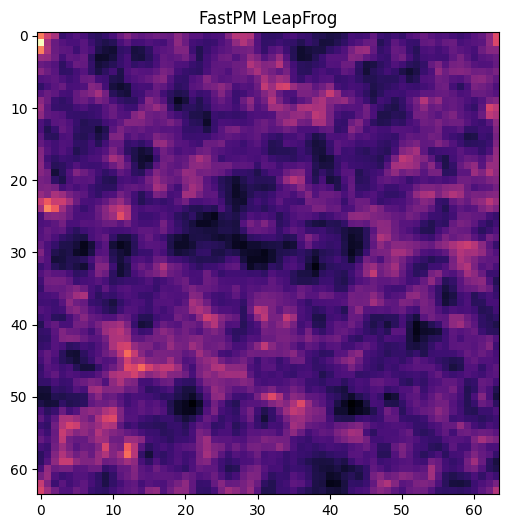

In [9]:
kick, drift = symplectic_ode(mesh_shape, paint_absolute_pos=False)
ode_terms = DoubleKickODETerm(kick), DriftODETerm(drift), KickODETerm(kick)

ode_solution_fpm, _ = run_nbody(
    params,
    initial_conditions,
    ode_terms,
    step_size=0.1,
    solver=EfficientLeapFrog(),
)
fpm_field = cic_paint_dx(ode_solution_fpm)


plt.figure(figsize=(12, 6))
plt.imshow(fpm_field[10:].sum(axis=0).data, cmap="magma")
plt.title("FastPM LeapFrog")


plt.show()

In [10]:
statelpt = solver.lpt(lineark, grid, 0.1, order=1)
stages = np.linspace(0.1, 1.0, 10, endpoint=True)

leapfrog_stages = leapfrog(stages)
finalstate = solver.nbody(statelpt, leapfrog_stages)
fpm_mesh = pm.paint(finalstate.X).value

In [11]:
def jax_mse(x, y):
    return ((x - y) ** 2).mean()


print(
    f"Difference between FPM and EfficientLeapFrog with 10 steps is {jax_mse(fpm_field.data , fpm_mesh )} "
)
print(
    f"Difference between FPM and SemiImpliciteEuler with 10 steps is {jax_mse(sie_field.data , fpm_mesh )} "
)

Difference between FPM and EfficientLeapFrog with 10 steps is 7.604728030477854e-13 
Difference between FPM and SemiImpliciteEuler with 10 steps is 0.9941474761203047 


In [12]:
kick, drift = symplectic_ode(mesh_shape, paint_absolute_pos=False)
ode_terms = DoubleKickODETerm(kick), DriftODETerm(drift), KickODETerm(kick)


gradients_rev, _ = nbody_ic(
    best_params,
    best_ic,
    fpm_field,
    ode_terms,
    solver=EfficientLeapFrog(),
    adjoint=REVERSE,
)
gradiennts_check, _ = nbody_ic(
    best_params,
    best_ic,
    fpm_field,
    ode_terms,
    solver=EfficientLeapFrog(),
    adjoint=CHECKPOINT,
)

print(
    f"Maximum difference between reverse and checkpoint gradients is {jnp.abs(gradients_rev.data - gradiennts_check.data).max()}"
)

Maximum difference between reverse and checkpoint gradients is 1.855425670960545e-18


In [13]:
kick, drift = symplectic_ode(mesh_shape, paint_absolute_pos=False)
ode_terms = DoubleKickODETerm(kick), DriftODETerm(drift), KickODETerm(kick)

ode_solution_fpm, _ = run_nbody(
    params,
    initial_conditions,
    ode_terms,
    step_size=0.01,
    solver=EfficientLeapFrog(),
)
obs_fpm_field = cic_paint_dx(ode_solution_fpm)

: 

In [ ]:
kick, drift = symplectic_ode(mesh_shape, paint_absolute_pos=False)
ode_terms = DoubleKickODETerm(kick), DriftODETerm(drift), KickODETerm(kick)
t1 = 1.0
t0 = 0.1


def constant_steps_model(solver, observable, adjoint, num_steps):
    step_size = (t1 - t0) / num_steps
    if adjoint == "finite_diff":

        def fn(guess_params):
            val, _ = nbody(
                guess_params,
                guess_ic,
                observable,
                ode_terms,
                step_size=step_size,
                solver=solver,
            )
            return val

        tangents = Params(jnp.array(1.0), jnp.array(0.0))
        grads = numerical_jvp(fn, (guess_params,), (tangents,), eps=1e-12)
        return grads, num_steps

    grads, steps = nbody_cosmo(
        guess_params,
        guess_ic,
        observable,
        ode_terms,
        step_size=step_size,
        solver=solver,
        adjoint=adjoint,
    )
    return grads.Omega_c, steps


def generate_gradient_data(solver, observable, adjoint, base_line_tol=90):
    gradients, steps = [], []
    print(
        f"running for {solver} with adjoint {adjoint} with base line tol {base_line_tol}"
    )
    for num_steps in tqdm(jnp.arange(10, 100, 10).tolist()):
        grad, num_steps = constant_steps_model(solver, observable, adjoint, num_steps)
        gradients.append(grad)
        steps.append(num_steps)

    return gradients, steps


base_fpm_grad, base_fpm_steps = constant_steps_model(
    EfficientLeapFrog(), obs_fpm_field, adjoint=CHECKPOINT, num_steps=90
)

fpm_grads_DTO, fpm_steps_DTO = generate_gradient_data(
    EfficientLeapFrog(), obs_fpm_field, adjoint=CHECKPOINT
)
fpm_grads_REV, fpm_steps_REV = generate_gradient_data(
    EfficientLeapFrog(), obs_fpm_field, adjoint=REVERSE
)
fpm_grads_fd, _ = generate_gradient_data(
    EfficientLeapFrog(), obs_fpm_field, "finite_diff"
)

running for EfficientLeapFrog() with adjoint GradientType.Checkpoint with base line tol 90


100%|██████████| 9/9 [30:02<00:00, 200.26s/it]


running for EfficientLeapFrog() with adjoint GradientType.Reverse with base line tol 90


100%|██████████| 9/9 [25:57<00:00, 173.01s/it]


running for EfficientLeapFrog() with adjoint finite_diff with base line tol 90


100%|██████████| 9/9 [03:49<00:00, 25.49s/it]


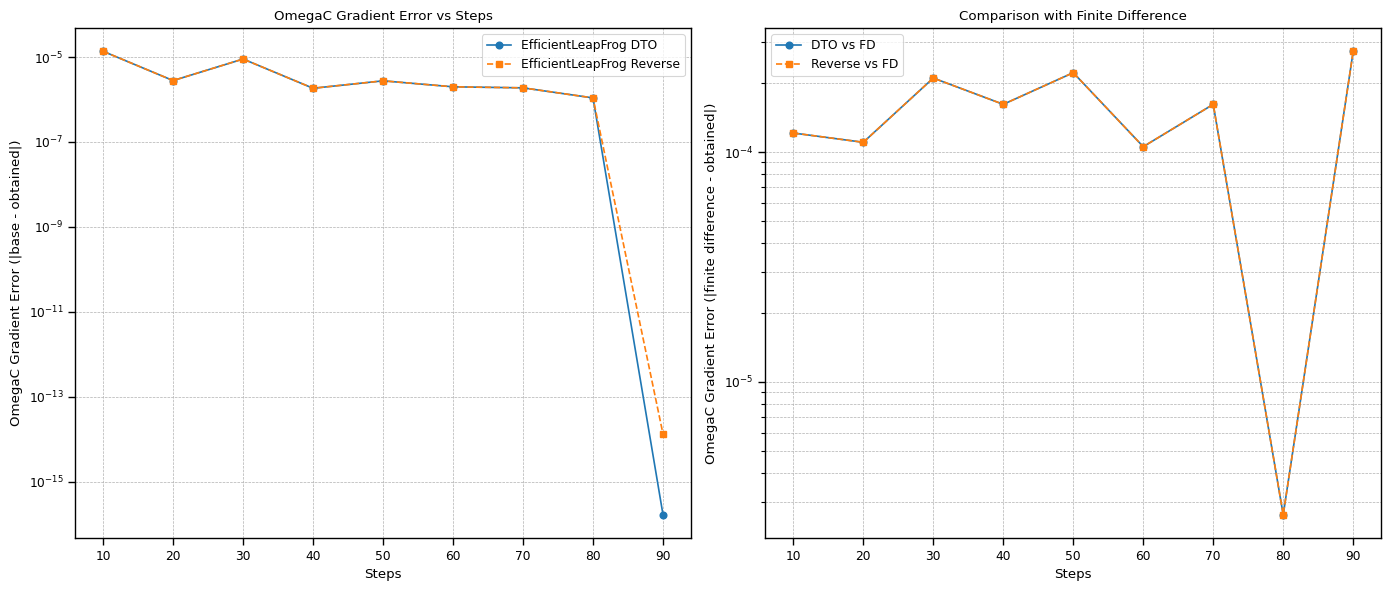

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_context("paper")

# Compute absolute errors
fpm_error_DTO = [abs(base_fpm_grad - grad) for grad in fpm_grads_DTO]
fpm_error_REV = [abs(base_fpm_grad - grad) for grad in fpm_grads_REV]

# Compute errors relative to finite differences
fpm_error_FD_DTO = [
    abs(fd_grad - dto_grad) for fd_grad, dto_grad in zip(fpm_grads_fd, fpm_grads_DTO)
]
fpm_error_FD_REV = [
    abs(fd_grad - otd_grad) for fd_grad, otd_grad in zip(fpm_grads_fd, fpm_grads_REV)
]

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot Gradient Error vs Steps in Subplot 1
ax1.plot(
    fpm_steps_DTO,
    fpm_error_DTO,
    marker="o",
    linestyle="-",
    label="EfficientLeapFrog DTO",
)
ax1.plot(
    fpm_steps_REV,
    fpm_error_REV,
    marker="s",
    linestyle="--",
    label="EfficientLeapFrog Reverse",
)

# Customize Subplot 1
ax1.set_yscale("log")  # Log scale for gradient errors
ax1.set_xlabel("Steps")
ax1.set_ylabel("OmegaC Gradient Error (|base - obtained|)")
ax1.set_title("OmegaC Gradient Error vs Steps")
ax1.legend()
ax1.grid(True, which="both", linestyle="--", linewidth=0.5)

# Plot Finite Difference Comparison in Subplot 2
ax2.plot(fpm_steps_DTO, fpm_error_FD_DTO, marker="o", linestyle="-", label="DTO vs FD")
ax2.plot(
    fpm_steps_REV, fpm_error_FD_REV, marker="s", linestyle="--", label="Reverse vs FD"
)

# Customize Subplot 2
ax2.set_yscale("log")  # Log scale for gradient errors
ax2.set_xlabel("Steps")
ax2.set_ylabel("OmegaC Gradient Error (|finite difference - obtained|)")
ax2.set_title("Comparison with Finite Difference")
ax2.legend()
ax2.grid(True, which="both", linestyle="--", linewidth=0.5)

# Adjust layout and save
plt.tight_layout()
plt.savefig("plots/GS_FPM_OmegaC_gradient_error.pdf", dpi=600, transparent=True)
plt.show()

In [40]:
kick, drift = symplectic_ode(mesh_shape, paint_absolute_pos=False)
ode_terms = DoubleKickODETerm(kick), DriftODETerm(drift), KickODETerm(kick)
t1, t0 = 1.0, 0.1
solver = EfficientLeapFrog()


def constant_steps_model(observable, adjoint, num_steps):
    step_size = (t1 - t0) / num_steps
    tangents = jax.random.normal(jax.random.PRNGKey(42), guess_ic.shape)
    tangents = jax.tree.unflatten(jax.tree.structure(guess_ic), (tangents,))
    if adjoint == "finite_diff":

        def fn(guess_ic):
            val, _ = nbody(
                guess_params,
                guess_ic,
                observable,
                ode_terms,
                step_size=step_size,
                solver=solver,
            )
            return val

        grads = numerical_jvp(fn, (guess_ic,), (tangents,), eps=1e-12)
        return grads, num_steps

    grads, steps = nbody_ic(
        guess_params,
        guess_ic,
        observable,
        ode_terms,
        step_size=step_size,
        solver=solver,
        adjoint=adjoint,
    )
    grads = (grads * tangents).sum()
    return grads.data, steps


def generate_gradient_data(observable, adjoint, base_line_tol=90):
    gradients, steps = [], []
    print(
        f"Running for EfficientLeapFrog with adjoint {adjoint} and baseline tol {base_line_tol}"
    )
    for num_steps in tqdm(jnp.arange(10, 100, 10).tolist()):
        grad, num_steps = constant_steps_model(observable, adjoint, num_steps)
        gradients.append(grad)
        steps.append(num_steps)
    return gradients, steps


base_fpm_grad, base_fpm_steps = constant_steps_model(
    obs_fpm_field, CHECKPOINT, num_steps=90
)
fpm_grads_DTO, fpm_steps_DTO = generate_gradient_data(obs_fpm_field, CHECKPOINT)
fpm_grads_REV, fpm_steps_REV = generate_gradient_data(obs_fpm_field, REVERSE)
fpm_grads_fd, _ = generate_gradient_data(obs_fpm_field, "finite_diff")

Running for EfficientLeapFrog with adjoint finite_diff and baseline tol 90


100%|██████████| 9/9 [03:50<00:00, 25.66s/it]


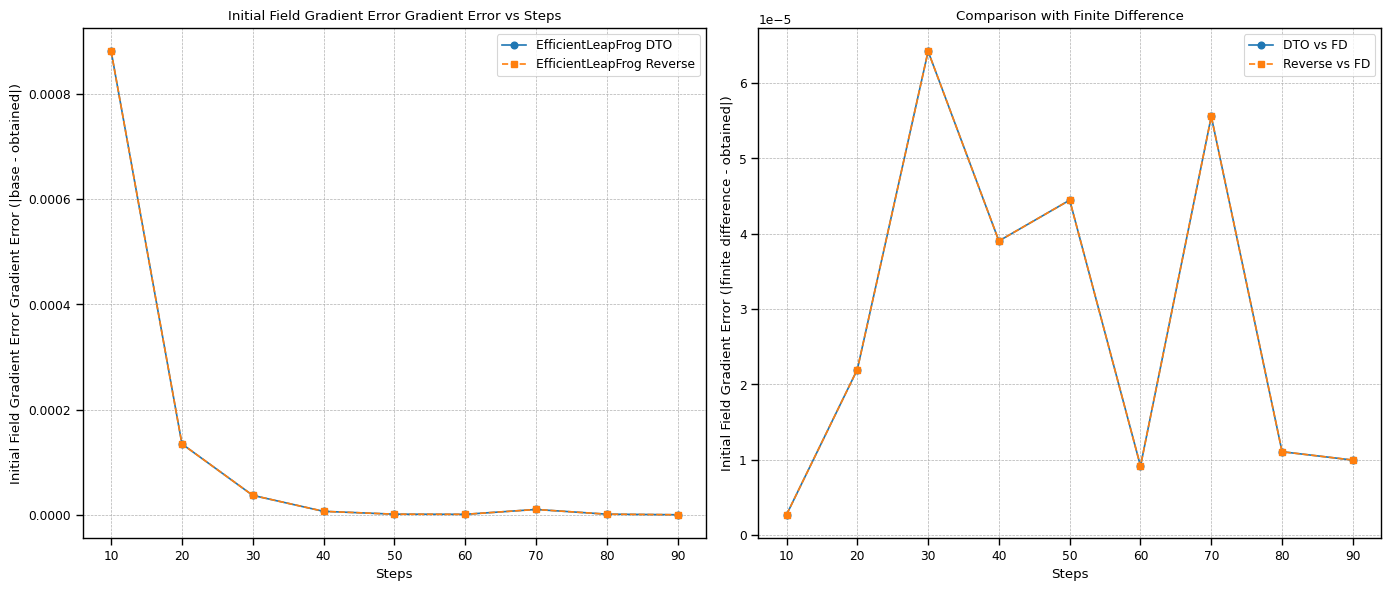

In [75]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_context("paper")

# Compute absolute errors
fpm_error_DTO = [abs(base_fpm_grad - grad) for grad in fpm_grads_DTO]
fpm_error_REV = [abs(base_fpm_grad - grad) for grad in fpm_grads_REV]

# Compute errors relative to finite differences
fpm_error_FD_DTO = [
    abs(fd_grad - dto_grad) for fd_grad, dto_grad in zip(fpm_grads_fd, fpm_grads_DTO)
]
fpm_error_FD_REV = [
    abs(fd_grad - otd_grad) for fd_grad, otd_grad in zip(fpm_grads_fd, fpm_grads_REV)
]

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot Gradient Error vs Steps in Subplot 1
ax1.plot(
    fpm_steps_DTO,
    fpm_error_DTO,
    marker="o",
    linestyle="-",
    label="EfficientLeapFrog DTO",
)
ax1.plot(
    fpm_steps_REV,
    fpm_error_REV,
    marker="s",
    linestyle="--",
    label="EfficientLeapFrog Reverse",
)

# Customize Subplot 1
ax1.set_xlabel("Steps")
ax1.set_ylabel("Initial Field Gradient Error Gradient Error (|base - obtained|)")
ax1.set_title("Initial Field Gradient Error Gradient Error vs Steps")
ax1.legend()
ax1.grid(True, which="both", linestyle="--", linewidth=0.5)

# Plot Finite Difference Comparison in Subplot 2
ax2.plot(fpm_steps_DTO, fpm_error_FD_DTO, marker="o", linestyle="-", label="DTO vs FD")
ax2.plot(
    fpm_steps_REV, fpm_error_FD_REV, marker="s", linestyle="--", label="Reverse vs FD"
)

# Customize Subplot 2
# ax2.set_yscale("log")  # Log scale for gradient errors
# ax2.set_ylim(1e-8, 1e-3)
ax2.set_xlabel("Steps")
ax2.set_ylabel("Initial Field Gradient Error (|finite difference - obtained|)")
ax2.set_title("Comparison with Finite Difference")
ax2.legend()
ax2.grid(True, which="both", linestyle="--", linewidth=0.5)

# Adjust layout and save
plt.tight_layout()
plt.savefig("plots/GS_FPM_initial_field_gradient_error.pdf", dpi=600, transparent=True)
plt.show()

In [ ]:
kick, drift = symplectic_ode(mesh_shape, paint_absolute_pos=False)
ode_terms = DoubleKickODETerm(kick), DriftODETerm(drift), KickODETerm(kick)
t1, t0 = 1.0, 0.1
solver = EfficientLeapFrog()


def constant_steps_memory(solver, observable, adjoint, num_steps, checkpoint=100):
    step_size = (t1 - t0) / num_steps

    @jax.jit
    def fn(guess_params):
        return nbody_cosmo(
            guess_params,
            guess_ic,
            observable,
            ode_terms,
            solver=solver,
            step_size=step_size,
            adjoint=adjoint,
            checkpoints=checkpoint,
        )

    grad, steps = fn(guess_params)
    memory = fn.lower(guess_params).compile().memory_analysis().temp_size_in_bytes
    return grad.Omega_c, num_steps, memory


def generate_memory_data(solver, observable, base_line_steps=90):
    gradients, steps, checkpoints, memories = [], [], [], []
    for checkpoint in tqdm(jnp.arange(20, 90, 10).tolist()):
        grad, num_steps, memory = constant_steps_memory(
            solver, observable, CHECKPOINT, num_steps=90, checkpoint=checkpoint
        )
        gradients.append(grad)
        steps.append(num_steps)
        checkpoints.append(checkpoint)
        memories.append(memory)

    return gradients, steps, checkpoints, memories


fpm_grad_base_DTO, fpm_steps_base_DTO, fpm_memories_base_DTO = constant_steps_memory(
    EfficientLeapFrog(), obs_fpm_field, CHECKPOINT, num_steps=90
)
fpm_grad_base_REV, fpm_steps_base_REV, fpm_memories_base_REV = constant_steps_memory(
    EfficientLeapFrog(), obs_fpm_field, REVERSE, num_steps=90
)

fpm_grads_DTO, fpm_steps_DTO, fpm_checkpoints_DTO, fpm_memories_DTO = (
    generate_memory_data(EfficientLeapFrog(), obs_fpm_field)
)

 43%|████▎     | 3/7 [12:45<16:52, 253.21s/it]